http://www.gregreda.com/2015/08/23/cohort-analysis-with-python/

In [1]:
import datetime
import pandas as pd
import sys

sys.path.append("/home/sergey/drclinics/reports")
sys.path.append("/home/sergey/drclinics/common")

from log import log
from utils import get_path, DATETIME_FORMAT
from report_utils import save_to_excel, send_mail
from connect_platform import connect_telemed

In [22]:
import numpy as np

In [2]:
sql = """
select 	a.patient_id,
        date(a.finished + 3 * interval '1 hour') appointment_finished
from appointment a 
where a.finished at time zone 'UTC' > '2020-03-30'
and a.good
  and not (
    a.patient_id in (
        select patient_id
        from patient_categories pcat
        inner join reference rf
           on rf.id=pcat.reference_id
        where rf.code='TEST'
        )
    or lower(a.report_comment)='тест'
    )
order by a.finished
"""

In [3]:
conn = connect_telemed()

2020-04-28 11:17:17 connect to postgres database using config file "/home/sergey/drclinics/common/../.credentials/telemed/prom.cfg"
2020-04-28 11:17:17 creating ssh tunnel to 172.16.100.19 as root...
2020-04-28 11:17:34 connect postgres using parameters:
                    database: telemed
				    user: norekhov
				    password: ***masked***
				    host: localhost
				    port: 44331
2020-04-28 11:17:34 @telemed: execute sql:
				    SET TIME ZONE 'Europe/Moscow'
				    None


In [4]:
df: pd.DataFrame = conn.query(sql)

2020-04-28 11:17:34 @telemed query:
                    select 	a.patient_id,
				            date(a.finished + 3 * interval '1 hour') appointment_finished
				    from appointment a 
				    where a.finished at time zone 'UTC' > '2020-03-30'
				    and a.good
				      and not (
				        a.patient_id in (
				            select patient_id
				            from patient_categories pcat
				            inner join reference rf
				               on rf.id=pcat.reference_id
				            where rf.code='TEST'
				            )
				        or lower(a.report_comment)='тест'
				        )
				    order by a.finished
                    None
2020-04-28 11:17:35 return 32736 rows


In [5]:
conn.close()

2020-04-28 11:17:35 @telemed: closing postgres connection...
2020-04-28 11:17:35 closing ssh tunnel to 172.16.100.19...


In [6]:
ret = ''

In [7]:
ret = pd.DataFrame(df)

In [8]:
ret.columns = ['id', 'date']

In [9]:
ret.head()

,id,date
0,2999269,2020-03-30
1,1128134,2020-03-30
2,2999335,2020-03-30
3,1642387,2020-03-30
4,2594981,2020-03-30


In [10]:
ret['date'] = pd.to_datetime(ret['date'], format='%Y/%m/%d')

In [11]:
ret.head()

,id,date
0,2999269,2020-03-30
1,1128134,2020-03-30
2,2999335,2020-03-30
3,1642387,2020-03-30
4,2594981,2020-03-30


In [12]:
ret['date_visit'] = ret.date.apply(lambda x: x.strftime('%m-%d'))

In [13]:
ret.set_index('id', inplace=True)

In [14]:
ret['date_join'] = ret.groupby(level=0)['date'].min().apply(lambda x: x.strftime('%m-%d'))

In [15]:
ret.reset_index(inplace=True)

In [17]:
ret[ret['id'] == 2999269]

,id,date,date_visit,date_join
0,2999269,2020-03-30,03-30,03-30
8644,2999269,2020-04-09,04-09,03-30


In [23]:
grouped = ret.groupby(['date_join', 'date_visit'])

In [24]:
cohorts = grouped.agg({'id': pd.Series.nunique})

In [25]:
cohorts

id
date_join date_visit     
03-30     03-30       488
          03-31        33
          04-01        29
          04-02        21
          04-03        17
...                   ...
04-26     04-27        92
          04-28        18
04-27     04-27       907
          04-28        36
04-28     04-28       223

[464 rows x 1 columns]

In [26]:
def cohort_period(df):
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts

id  CohortPeriod
date_join date_visit                   
03-30     03-30       488             1
          03-31        33             2
          04-01        29             3
          04-02        21             4
          04-03        17             5
...                   ...           ...
04-26     04-27        92             2
          04-28        18             3
04-27     04-27       907             1
          04-28        36             2
04-28     04-28       223             1

[464 rows x 2 columns]

# Cohorts2

In [27]:
cohorts2 = cohorts

In [28]:
cohorts2.reset_index(inplace=True)
cohorts2.set_index(['date_join', 'CohortPeriod'], inplace=True)

In [29]:
cohorts2

date_visit   id
date_join CohortPeriod                
03-30     1                 03-30  488
          2                 03-31   33
          3                 04-01   29
          4                 04-02   21
          5                 04-03   17
...                           ...  ...
04-26     2                 04-27   92
          3                 04-28   18
04-27     1                 04-27  907
          2                 04-28   36
04-28     1                 04-28  223

[464 rows x 2 columns]

In [30]:
cohort_group_size = []

In [31]:
cohort_group_size = cohorts2['id'].groupby(level=0).first()

In [32]:
cohort_group_size

date_join
03-30    488
03-31    490
04-01    578
04-02    584
04-03    651
04-04    571
04-05    545
04-06    735
04-07    689
04-08    785
04-09    668
04-10    594
04-11    465
04-12    580
04-13    707
04-14    640
04-15    687
04-16    676
04-17    758
04-18    687
04-19    588
04-20    953
04-21    955
04-22    935
04-23    967
04-24    981
04-25    694
04-26    618
04-27    907
04-28    223
Name: id, dtype: int64

In [33]:
cohorts2['id'].unstack(0)

date_join,03-30,03-31,04-01,04-02,04-03,04-04,04-05,04-06,04-07,04-08,...,04-19,04-20,04-21,04-22,04-23,04-24,04-25,04-26,04-27,04-28
CohortPeriod,,,,,,,,,,,,,,,,,,,,,
1,488.0,490.0,578.0,584.0,651.0,571.0,545.0,735.0,689.0,785.0,...,588.0,953.0,955.0,935.0,967.0,981.0,694.0,618.0,907.0,223.0
2,33.0,25.0,33.0,38.0,23.0,35.0,36.0,49.0,53.0,50.0,...,69.0,123.0,120.0,116.0,191.0,127.0,90.0,92.0,36.0,NaN
3,29.0,24.0,30.0,12.0,22.0,15.0,24.0,42.0,27.0,35.0,...,77.0,106.0,98.0,100.0,154.0,93.0,84.0,18.0,NaN,NaN
4,21.0,22.0,14.0,16.0,21.0,26.0,19.0,21.0,20.0,24.0,...,72.0,110.0,94.0,68.0,146.0,101.0,17.0,NaN,NaN,NaN
5,17.0,16.0,19.0,18.0,23.0,21.0,20.0,23.0,17.0,15.0,...,55.0,98.0,73.0,54.0,153.0,29.0,NaN,NaN,NaN,NaN
6,23.0,11.0,26.0,11.0,23.0,14.0,13.0,11.0,15.0,26.0,...,64.0,77.0,66.0,73.0,40.0,NaN,NaN,NaN,NaN,NaN
7,14.0,9.0,10.0,13.0,12.0,15.0,16.0,12.0,18.0,17.0,...,49.0,43.0,45.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN
8,23.0,8.0,21.0,23.0,28.0,18.0,12.0,17.0,17.0,23.0,...,48.0,65.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,17.0,11.0,11.0,12.0,11.0,11.0,12.0,23.0,13.0,22.0,...,35.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
user_retention = []

In [35]:
user_retention = cohorts2['id'].unstack(0).divide(cohort_group_size, axis=1)

In [36]:
user_retention

date_join,03-30,03-31,04-01,04-02,04-03,04-04,04-05,04-06,04-07,04-08,...,04-19,04-20,04-21,04-22,04-23,04-24,04-25,04-26,04-27,04-28
CohortPeriod,,,,,,,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.067623,0.051020,0.057093,0.065068,0.035330,0.061296,0.066055,0.066667,0.076923,0.063694,...,0.117347,0.129066,0.125654,0.124064,0.197518,0.129460,0.129683,0.148867,0.039691,NaN
3,0.059426,0.048980,0.051903,0.020548,0.033794,0.026270,0.044037,0.057143,0.039187,0.044586,...,0.130952,0.111228,0.102618,0.106952,0.159255,0.094801,0.121037,0.029126,NaN,NaN
4,0.043033,0.044898,0.024221,0.027397,0.032258,0.045534,0.034862,0.028571,0.029028,0.030573,...,0.122449,0.115425,0.098429,0.072727,0.150982,0.102956,0.024496,NaN,NaN,NaN
5,0.034836,0.032653,0.032872,0.030822,0.035330,0.036778,0.036697,0.031293,0.024673,0.019108,...,0.093537,0.102833,0.076440,0.057754,0.158221,0.029562,NaN,NaN,NaN,NaN
6,0.047131,0.022449,0.044983,0.018836,0.035330,0.024518,0.023853,0.014966,0.021771,0.033121,...,0.108844,0.080797,0.069110,0.078075,0.041365,NaN,NaN,NaN,NaN,NaN
7,0.028689,0.018367,0.017301,0.022260,0.018433,0.026270,0.029358,0.016327,0.026125,0.021656,...,0.083333,0.045121,0.047120,0.014973,NaN,NaN,NaN,NaN,NaN,NaN
8,0.047131,0.016327,0.036332,0.039384,0.043011,0.031524,0.022018,0.023129,0.024673,0.029299,...,0.081633,0.068206,0.009424,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.034836,0.022449,0.019031,0.020548,0.016897,0.019264,0.022018,0.031293,0.018868,0.028025,...,0.059524,0.009444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
sns.set(style='white')

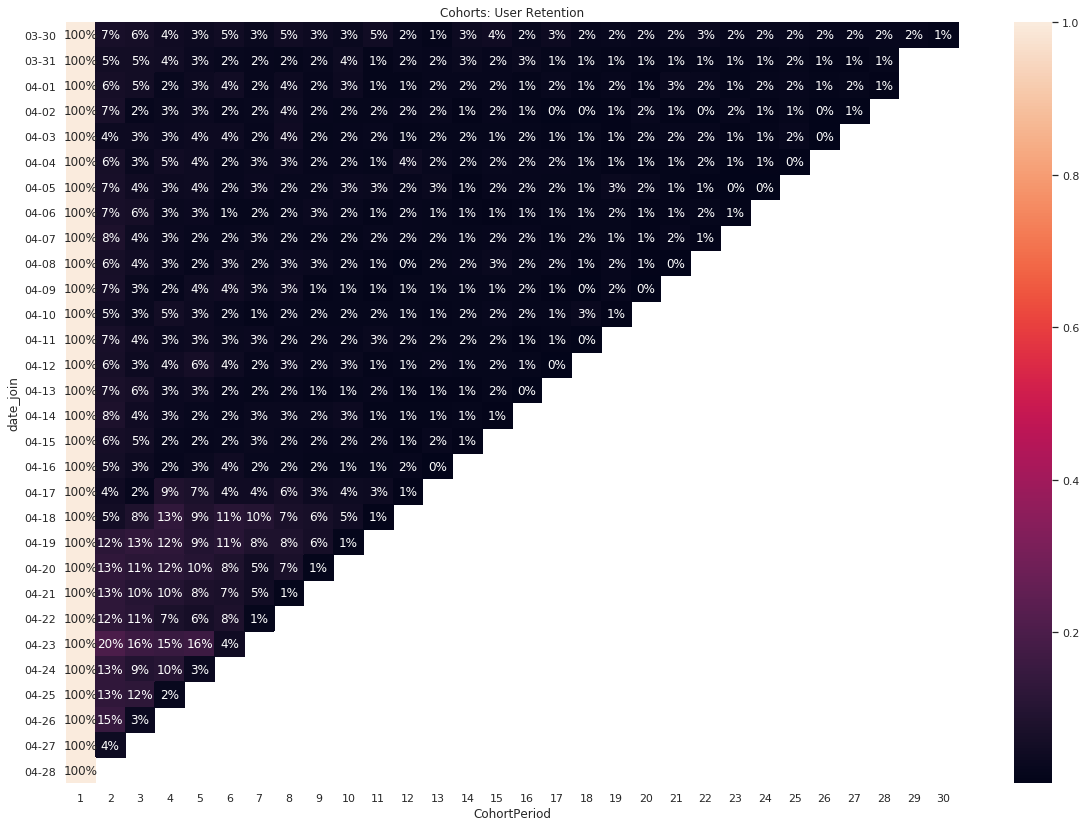

In [39]:
plt.figure(figsize=(20, 14))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

# Cohorts 3

In [40]:
cohorts3 = cohorts

In [41]:
cohorts3.reset_index(inplace=True)
cohorts3.set_index(['CohortPeriod', 'date_join'], inplace=True)

In [42]:
cohort_group_size2 = cohorts3['id'].groupby(level=1).first()

In [43]:
cohort_group_size2

date_join
03-30    488
03-31    490
04-01    578
04-02    584
04-03    651
04-04    571
04-05    545
04-06    735
04-07    689
04-08    785
04-09    668
04-10    594
04-11    465
04-12    580
04-13    707
04-14    640
04-15    687
04-16    676
04-17    758
04-18    687
04-19    588
04-20    953
04-21    955
04-22    935
04-23    967
04-24    981
04-25    694
04-26    618
04-27    907
04-28    223
Name: id, dtype: int64

In [44]:
cohorts3['id'].head()

CohortPeriod  date_join
1             03-30        488
2             03-30         33
3             03-30         29
4             03-30         21
5             03-30         17
Name: id, dtype: int64

In [45]:
cohorts3['id'].unstack(0)

CohortPeriod,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
date_join,,,,,,,,,,,,,,,,,,,,,
03-30,488.0,33.0,29.0,21.0,17.0,23.0,14.0,23.0,17.0,14.0,...,12.0,14.0,10.0,11.0,12.0,9.0,9.0,9.0,9.0,5.0
03-31,490.0,25.0,24.0,22.0,16.0,11.0,9.0,8.0,11.0,19.0,...,6.0,6.0,6.0,5.0,8.0,3.0,4.0,7.0,NaN,NaN
04-01,578.0,33.0,30.0,14.0,19.0,26.0,10.0,21.0,11.0,19.0,...,15.0,14.0,6.0,9.0,10.0,7.0,9.0,4.0,NaN,NaN
04-02,584.0,38.0,12.0,16.0,18.0,11.0,13.0,23.0,12.0,9.0,...,4.0,2.0,12.0,5.0,8.0,1.0,3.0,NaN,NaN,NaN
04-03,651.0,23.0,22.0,21.0,23.0,23.0,12.0,28.0,11.0,12.0,...,12.0,12.0,6.0,7.0,14.0,1.0,NaN,NaN,NaN,NaN
04-04,571.0,35.0,15.0,26.0,21.0,14.0,15.0,18.0,11.0,11.0,...,6.0,9.0,3.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN
04-05,545.0,36.0,24.0,19.0,20.0,13.0,16.0,12.0,12.0,16.0,...,7.0,5.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
04-06,735.0,49.0,42.0,21.0,23.0,11.0,12.0,17.0,23.0,17.0,...,9.0,12.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04-07,689.0,53.0,27.0,20.0,17.0,15.0,18.0,17.0,13.0,11.0,...,14.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
